# Toy models of superposition

In this notebook, I want to explore some questions about superposition using toy models.
Feature superposition in GPT-like models is the phenomenon where a model represents a large set of sparse features in a smaller activation space.
Recent work has suggested that this happens in toy models, that sparse autoencoders can recover linearly superimposed sparse features, and that a similar sparse encoding recovers interpretable features in small real models.
If we assume that the transformer residual stream indeed displays this kind of structure, it is natural to assumume that the computational graph of the network can also be interpreted with a lens of "what does it compute if we decompose the residual stream into interpretable features?". The intuition behind this is that no useful compution relates completely unrelated features (i.e. presence of the feature 'oat milk' should not be used to construct a feature 'python docstring' in the next layer).

In this notebook, I want to explore the explore the implications of different assumptions we make about the (sparse -> dense) feature representation.

- how sensitive is the autoencoder to gt feature distribution? what can we recover, what can we not?
  - this matters because we dont want to make wrong assumptions about how features are represented and then become blind to anything that doesn't fit
- which autoencoder setup allows the model to "easily compute meaningful things in terms of sparse features" while working with the superimposed representation?
  - this matters because if we extract 'features' that the model basically has no access to (cannot easily use for computations), we will not find features that the model uses for computations 

## Method
- make most simple dataset, autoencoder setup possible
  - train the model
  - make visualizations
    - reconstruction heatmap (W W.T)
    - given feature f is not active, how does the noise generated by other features look like? -> pdf
- vary dataset, autoencoder and check:
  - total reconstruction performance?
  - effect of activation function on generated noise?


## Related questions
- What happens to their ReLU output model when there's non-uniform sparsity? E.g, one class of less sparse features and another of very sparse
- Adapt their ReLU output model to have a different range of feature values, and see how this affects things. Make the features 1 (i.e, two possible values)
- Adapt their ReLU output model to have a different range of feature values, and see how this affects things. Make the features discrete (1, 2, 3)
- Adapt their ReLU output model to have a different range of feature values, and see how this affects things. Make the features uniform [0.5, 1]
- What happens if you replace ReLU's with GeLU's in the toy models?



## Notes
- once we have 

## Utils

(8, 2)


<Figure size 640x480 with 0 Axes>

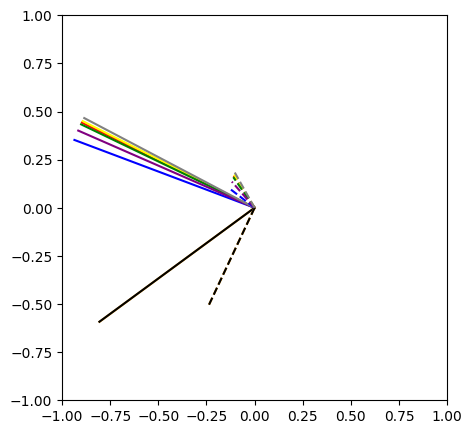

'images/None/None'

In [88]:
import re
from IPython.display import Video, display

colors = [
    'red',
    'blue',
    'yellow',
    'green',
    'orange',
    'purple',
    'black',
    'grey',
]

def plot_embeddings(ae, title=None, step=None, experiment_name=None):
    plt.clf()
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes = [axes]

    # Plot for Encoder
    embeddings_enc = ae.W_enc.detach().cpu().numpy().T
    # axes[0].set_title('Encoder')
    for color_id, i in enumerate(embeddings_enc):
        axes[0].plot([0, i[0]], [0, i[1]], color=colors[color_id])
    axes[0].set_xlim(-1, 1)
    axes[0].set_ylim(-1, 1)
    axes[0].set_aspect('equal', adjustable='box')

    # Plot for Decoder
    embeddings_dec = ae.W_dec.detach().cpu().numpy()
    print(embeddings_dec.shape)
    # axes[0].set_title('Decoder')
    for color_id, i in enumerate(embeddings_dec):
        axes[0].plot([0, i[0]], [0, i[1]], '--', color=colors[color_id])
    axes[0].set_xlim(-1, 1)
    axes[0].set_ylim(-1, 1)
    axes[0].set_aspect('equal', adjustable='box')

    try:
        dirname = f"images/{experiment_name}/{title}"
        os.makedirs(dirname, exist_ok=True)
        filename = f"{dirname}/{step:05d}.png"
        plt.savefig(filename)
    except:
        plt.show()
    return dirname

plot_embeddings(ae)

In [89]:



# Function to create a video from images in a folder
def create_video_from_images(folder_path, video_length=10):
    # Get list of image files sorted by name
    output_path = os.path.join(folder_path, "video.mp4")
    images = sorted(
        [img for img in os.listdir(folder_path) if re.match(r'\d+.png', img)],
        key=lambda x: int(re.match(r'(\d+).png', x).group(1))
    )
    if not images:
        raise ValueError('No images found in the folder.')

    # Calculate framerate based on the number of images and desired video length
    framerate = max(len(images) / video_length, 1)

    # Construct ffmpeg command
    ffmpeg_cmd = f"ffmpeg -y -framerate {framerate} -pattern_type glob -i '{folder_path}/*.png' -c:v libx264 -r 30 -pix_fmt yuv420p '{output_path}' &> /dev/null"
    os.system(ffmpeg_cmd)
    display(Video(output_path, embed=True))

folder_path = "/Users/nielswarncke/Documents/code/TransformerLens/demos/automated-interpretability/images/Reconstruction of each individual sparse feature (Identity is ideal)"
create_video_from_images(folder_path)
print("Yo")


Yo


## Dataset

In [90]:
from dataclasses import dataclass
import torch
import numpy as np


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

print(device)



@dataclass
class DataConfig:
    d_model: int = 128         # residual stream dimension
    d_sparse: int = 8 * 128    # gt sparse feature dimension
    p_active: float = 1e-2      # probability that a feature is activated
    
    

class Data():
    def __init__(self, cfg):
        self.cfg = cfg
    
    def batch(self, N=1024):
        x = np.random.uniform(0, 1, size=(N, self.cfg.d_sparse))
        active = np.random.uniform(0, 1, size=(N, self.cfg.d_sparse)) < self.cfg.p_active
        x = x * active
        x = torch.as_tensor(x, dtype=torch.float32).to(device)
        return x
        
        
data = Data(DataConfig(p_active=0.1))
h = data.batch(10)
h, h.shape, h.dtype

mps


(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7817, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='mps:0'),
 torch.Size([10, 1024]),
 torch.float32)

## Autoencoder

In [96]:
from torch.nn import functional as F
from torch import nn
from fancy_einsum import einsum


@dataclass
class AutoencoderConfig:
    d_model: int = 128
    d_sparse: int = 8 * 128
    
    normalize_w_enc: bool = True
    normalize_w_dec: bool = True
    init_transposed: bool = False
    use_activation_on_latents: bool = False
    
    init_range: float = 0.02
    
    w_loss_sparse: float = 0.1
    w_loss_mse: int = 1
    
    activation_fn: str = 'relu'
    
    def as_string(self):
        out = []
        for k, v in self.__dict__.items():
            if isinstance(v, bool):
                if v:
                    out += [k]
            else:
                out += [f"{k}: {v}"]
        return "|".join(out)

    
activation_functions = {
    'linear': lambda i: i,
    'relu': F.relu,
    'gelu': F.gelu,
    # 'solu': solu,
}


class Autoencoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(torch.empty((cfg.d_model, cfg.d_sparse)))
        nn.init.normal_(self.W_enc, std=self.cfg.init_range)
        if self.cfg.normalize_w_enc:
            self.normalize_w_enc()
            
        self.b_dec = nn.Parameter(torch.zeros((cfg.d_model)))
        self.W_dec = nn.Parameter(torch.empty((cfg.d_sparse, cfg.d_model)))
        
        if self.cfg.init_transposed:
            # Init W_dec with the transposed W_enc
            with torch.no_grad():
                self.W_dec.copy_(self.W_enc.t())
        else:
            nn.init.normal_(self.W_dec, std=self.cfg.init_range)
            if self.cfg.normalize_w_dec:
                self.normalize_w_dec()
                
        self.activation_fn = activation_functions[cfg.activation_fn]
        
    def normalize_w_enc(self):
        # Normalize columns of W_enc
        with torch.no_grad():
            norm = self.W_enc.norm(p=2, dim=0, keepdim=True)
            self.W_enc.div_(norm)
        
    def normalize_w_dec(self):
        # Normalize columns of W_enc
        with torch.no_grad():
            norm = self.W_dec.norm(p=2, dim=1, keepdim=True)
            self.W_dec.div_(norm)
    
    def encode(self, x):
        # x: [batch, position, d_model]
        # y: [batch, position, d_sparse]
        h = einsum("batch d_model, d_model d_mlp -> batch d_mlp", x, self.W_enc)
        h = self.activation_fn(h)
        return h
    
    def decode(self, h):
        x = einsum("batch d_model, d_model d_mlp -> batch d_mlp", h, self.W_dec) + self.b_dec
        # x = self.activation_fn(x)
        return x
    
    def loss_fn(self, x):
        h = self.encode(x)
        x_hat = self.decode(h)
        
        loss_mse = F.mse(x, x_hat)
        loss_sparse = h.mean()
        
        loss = self.cfg.w_loss_sparse * loss_sparse + self.cfg.w_loss_mse * loss_mse
        return loss

AutoencoderConfig().as_string()

'd_model: 128|d_sparse: 1024|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu'

### First check - can this model decode and encode the sparse features?

- we use the autoencoder reversed to check if it can at all represent superimposed features and recover them
   data --decode--> x --encode--> data'
- this is different from how we would use it in a real model because it requires access to the gt sparse features

In [92]:
ae = Autoencoder(AutoencoderConfig(d_model=128, d_sparse=1024))
ae.to(device)

def decode_encode(h):
    x = ae.decode(h)
    h_hat = ae.encode(x)
    return h_hat

h = data.batch(10)


losses = []

h_basis = torch.as_tensor(
    np.eye(data.cfg.d_sparse),
    dtype=torch.float32
).to(device)

h_eval = data.batch(1024)


In [93]:
from matplotlib import pyplot as plt
from torch import optim

def imshow(img, title, step, experiment_name):
    plt.close("all")
    dirname = f"images/{experiment_name}/{title}"
    os.makedirs(dirname, exist_ok=True)
    filename = f"{dirname}/{step:05d}.png"
    print(filename)
    if not isinstance(img, np.ndarray):
        img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.colorbar()
    plt.savefig(filename)
    plt.clf()
    return dirname
    

def experiment1(
    ae_config=AutoencoderConfig(d_model=128, d_sparse=1024),
    data_config=DataConfig(p_active=0.1),
    num_steps=1000 * 10
):
    batch_size = 1024

    h_basis_losses = []
    h_eval_losses = []
    train_losses = []
    steps = []

    ae = Autoencoder(ae_config)
    ae.to(device)
    
    data = Data(data_config)
    h_basis = torch.as_tensor(
        np.eye(data.cfg.d_sparse),
        dtype=torch.float32
    ).to(device)
    h_eval = data.batch(1024)
    print(h_eval.shape)
    

    optimizer = optim.Adam(ae.parameters(), lr=1e-3)  
    ae.train()  


    exp_steps = [2**i for i in range(7, 20)]
    eval_steps = [i * 100 for i in range(1000)]

    h_basis_title = "Reconstruction of h_basis"
    
    
    
    def decode_encode(h):
        x = ae.decode(h)
        h_hat = ae.encode(x)
        return h_hat


    for i in range(num_steps):
        # Do a train step
        optimizer.zero_grad()
        
        # Forward
        h = data.batch(batch_size)
        h_hat = decode_encode(h)
        loss = F.mse_loss(h, h_hat)
            
        # Backward
        loss.backward()  
            
        # Update the model parameters  
        optimizer.step()
        if ae.cfg.normalize_w_enc:
            ae.normalize_w_enc()
            
        # Accumulate the loss  
        train_losses += [loss.item()]
        
        if i in eval_steps:
            # collect some stats
            h_basis_hat = decode_encode(h_basis)
            h_basis_loss = F.mse_loss(h_basis, h_basis_hat)
            h_eval_hat = decode_encode(h_eval)
            h_eval_loss = F.mse_loss(h_eval, h_eval_hat)
            print(i, h_eval_loss)
            folder_path = imshow(
                h_basis_hat,
                h_basis_title,
                step=i,
                experiment_name=f"{ae.cfg.as_string()}|simple-dataset"
            )
            if ae.cfg.d_model == 2:
                embedding_plots = plot_embeddings(
                    ae,
                    "2d embeddings",
                    step=i,
                    experiment_name=f"{ae.cfg.as_string()}|simple-dataset"
                )
            h_basis_losses += [h_basis_loss.detach().cpu().numpy()] 
            h_eval_losses += [h_eval_loss.detach().cpu().numpy()] 
            steps += [i]
            
    plt.clf()
    plt.plot(list(range(i + 1)), train_losses, label="Train loss", alpha=0.3)
    plt.plot(steps, h_basis_losses, label="Individual feature rec. loss")
    plt.plot(steps, h_eval_losses, label="Avg rec. loss")
    plt.legend()
    plt.show()
            
    create_video_from_images(folder_path)
    if ae.cfg.d_model == 2:
        create_video_from_images(embedding_plots)
    
    return ae




## 2d experiments

d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 8])
0 tensor(0.0867, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(8, 2)
100 tensor(0.0589, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(8, 2)
200 tensor(0.0443, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(8, 2)
300 tensor(0.0359, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|nor

<Figure size 640x480 with 0 Axes>

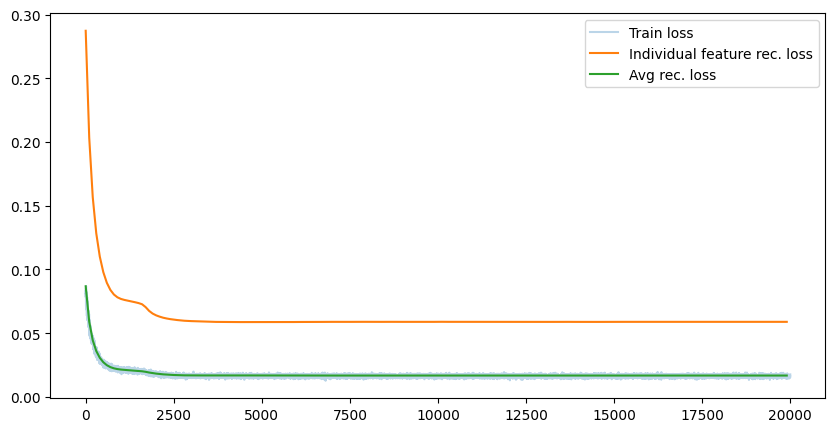

In [95]:
cfg = AutoencoderConfig(d_model=2, d_sparse=8)
print(cfg.as_string())

ae = experiment1(
    ae_config=cfg,
    data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
    num_steps=20000
)

We see a small double descent, and we see how the features arrange in a kind of understandable way: it collapses to 5 features but arranges them with maximum distance and pairs the encoder and decoder weights close to each other.

What happens if we only use 5 features?

d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 5])
0 tensor(0.0585, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(5, 2)
100 tensor(0.0480, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(5, 2)
200 tensor(0.0420, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(5, 2)
300 tensor(0.0375, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|nor

<Figure size 640x480 with 0 Axes>

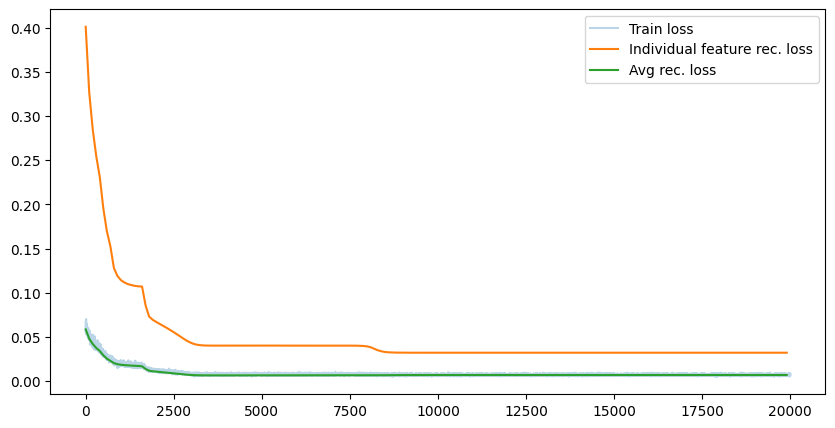

In [97]:
cfg = AutoencoderConfig(d_model=2, d_sparse=5)
print(cfg.as_string())

ae = experiment1(
    ae_config=cfg,
    data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
    num_steps=20000
)

This looks very cool! There is a clear phase change when the model switches from using 4 features to using 5 features

What happens if we init the weights transposed?

d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 8])
0 tensor(0.0507, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(8, 2)
100 tensor(0.0393, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(8, 2)
200 tensor(0.0323, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 8|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(8, 2)
300 tensor(0.0272, device='mps:0

<Figure size 640x480 with 0 Axes>

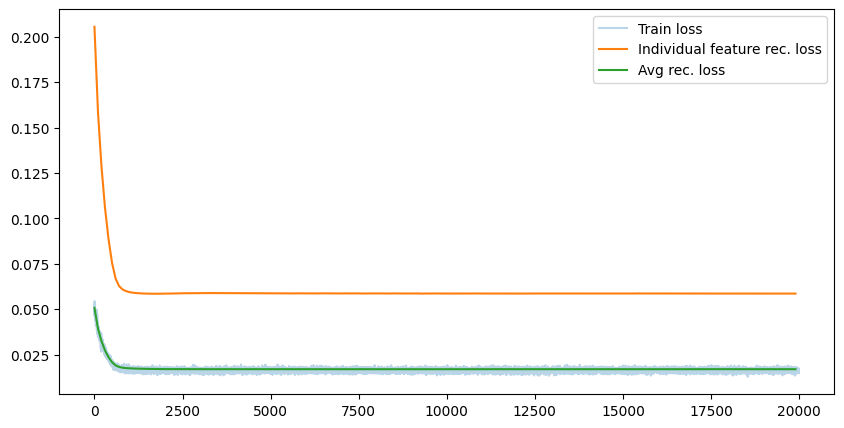

In [100]:
cfg = AutoencoderConfig(d_model=2, d_sparse=8, init_transposed=True)
print(cfg.as_string())

ae = experiment1(
    ae_config=cfg,
    data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
    num_steps=20000
)

What happens if we vary the number of features

d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 2])
0 tensor(0.0207, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(2, 2)
100 tensor(0.0181, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(2, 2)
200 tensor(0.0176, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(2, 2)
300 tensor(0.0164, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|nor

<Figure size 640x480 with 0 Axes>

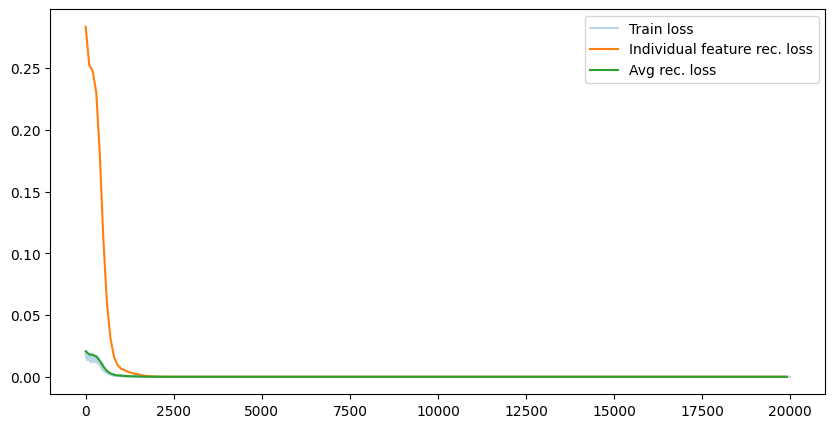

d_model: 2|d_sparse: 3|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 3])
0 tensor(0.0297, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 3|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(3, 2)
100 tensor(0.0252, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 3|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(3, 2)
200 tensor(0.0234, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 3|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(3, 2)
300 tensor(0.0229, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 3|nor

<Figure size 640x480 with 0 Axes>

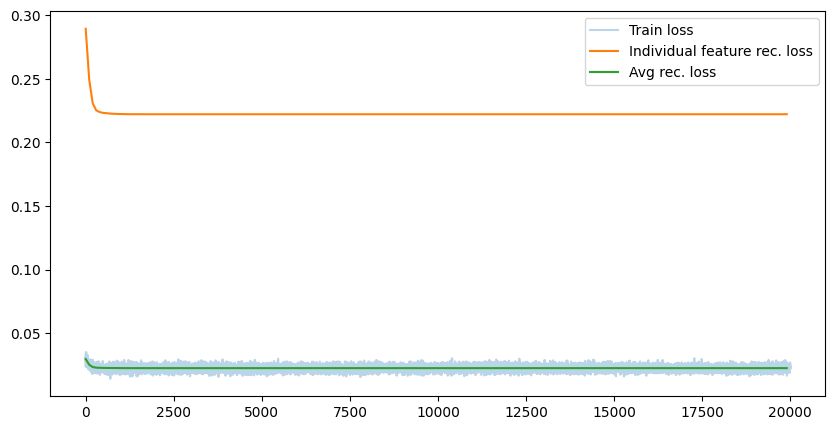

d_model: 2|d_sparse: 4|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 4])
0 tensor(0.0621, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 4|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(4, 2)
100 tensor(0.0518, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 4|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(4, 2)
200 tensor(0.0441, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 4|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(4, 2)
300 tensor(0.0368, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 4|nor

<Figure size 640x480 with 0 Axes>

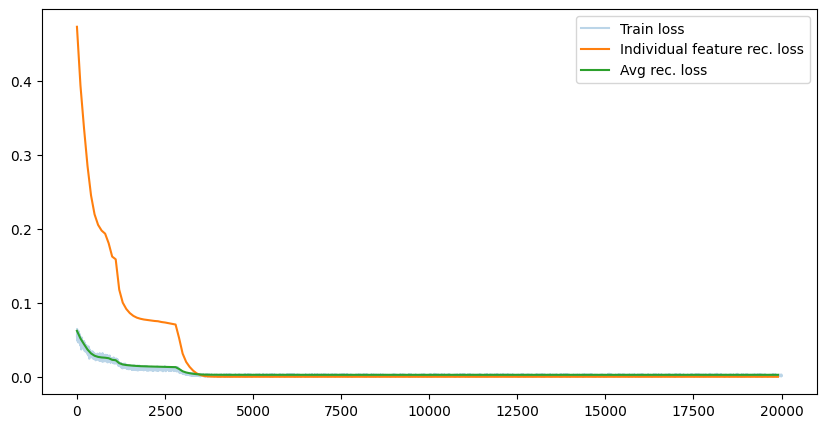

d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 5])
0 tensor(0.0831, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(5, 2)
100 tensor(0.0614, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(5, 2)
200 tensor(0.0480, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(5, 2)
300 tensor(0.0398, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 5|nor

<Figure size 640x480 with 0 Axes>

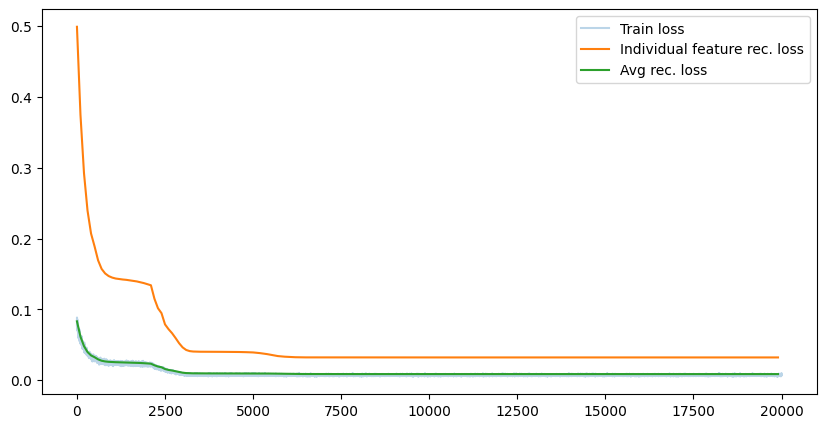

d_model: 2|d_sparse: 6|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 6])
0 tensor(0.0841, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 6|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(6, 2)
100 tensor(0.0654, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 6|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(6, 2)
200 tensor(0.0544, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 6|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(6, 2)
300 tensor(0.0462, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 6|nor

<Figure size 640x480 with 0 Axes>

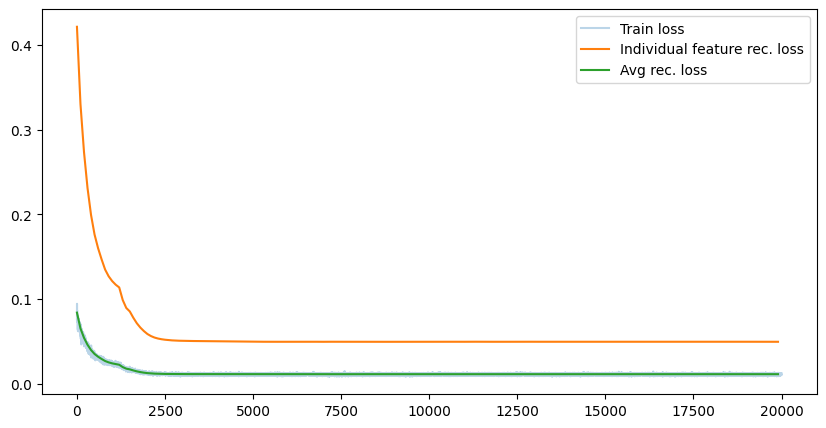

d_model: 2|d_sparse: 7|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 7])
0 tensor(0.0637, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 7|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
(7, 2)
100 tensor(0.0510, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 7|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
(7, 2)
200 tensor(0.0423, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 7|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
(7, 2)
300 tensor(0.0349, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 7|nor

<Figure size 640x480 with 0 Axes>

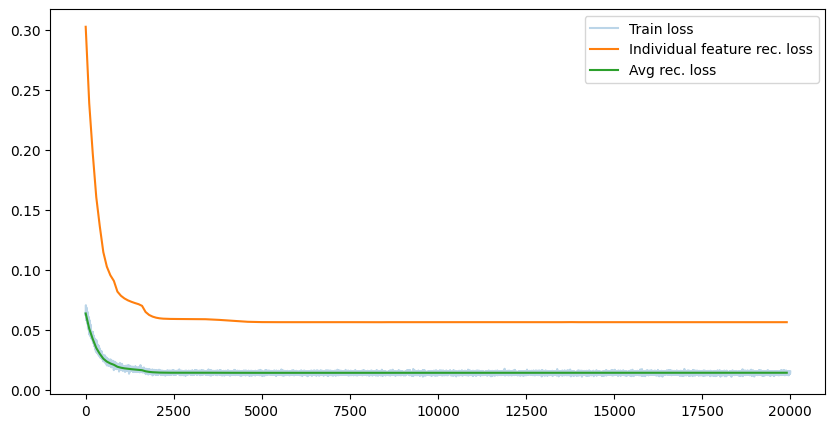

In [101]:
for d_sparse in [2, 3, 4, 5, 6, 7]:
    cfg = AutoencoderConfig(d_model=2, d_sparse=d_sparse, init_transposed=False)
    print(cfg.as_string())

    ae = experiment1(
        ae_config=cfg,
        data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
        num_steps=20000
    )

d_model: 128|d_sparse: 1024|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu
torch.Size([1024, 1024])
0 tensor(0.1301, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 128|d_sparse: 1024|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00000.png
100 tensor(0.0271, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 128|d_sparse: 1024|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00100.png
200 tensor(0.0266, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 128|d_sparse: 1024|normalize_w_enc|normalize_w_dec|init_transposed|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: relu|simple-dataset/Reconstruction of h_basis/00200.png
300 tensor(0.0262, device='mps

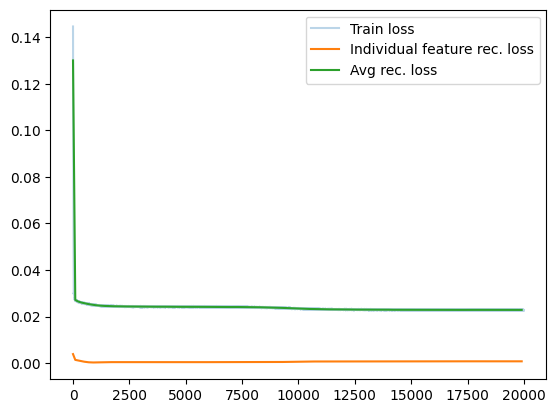

In [102]:
cfg = AutoencoderConfig(d_model=128, d_sparse=1024, init_transposed=True)
print(cfg.as_string())

ae = experiment1(
    ae_config=cfg,
    data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
    num_steps=20000
)

What happens in a 2d->2d setting?

The ideal solution is to simply create two orthogonal layers. Since we use relu in this experiment with always positive inputs, negative weights are basically dead.
Let's first do it without any activation function to check that the simple linear case at least works

d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: linear
torch.Size([1024, 2])
0 tensor(0.0474, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: linear|simple-dataset/Reconstruction of h_basis/00000.png
(2, 2)
100 tensor(0.0325, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: linear|simple-dataset/Reconstruction of h_basis/00100.png
(2, 2)
200 tensor(0.0250, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_sparse: 2|normalize_w_enc|normalize_w_dec|init_range: 0.02|w_loss_sparse: 0.1|w_loss_mse: 1|activation_fn: linear|simple-dataset/Reconstruction of h_basis/00200.png
(2, 2)
300 tensor(0.0205, device='mps:0', grad_fn=<MseLossBackward0>)
images/d_model: 2|d_spars

<Figure size 640x480 with 0 Axes>

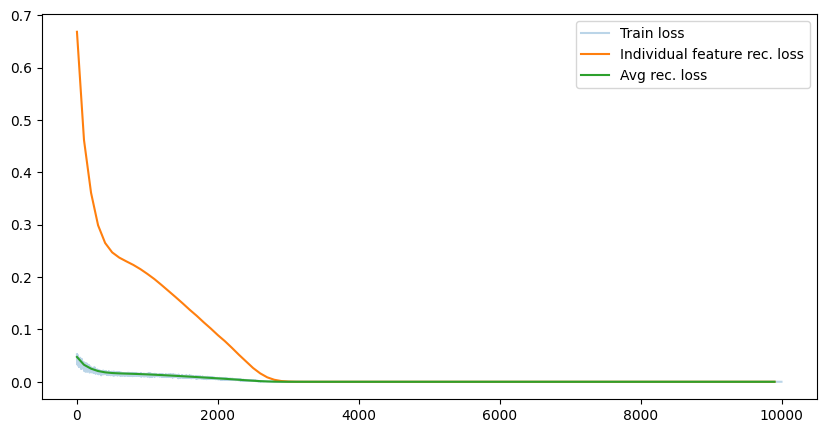

In [105]:
cfg = AutoencoderConfig(d_model=2, d_sparse=2, activation_fn='linear')
print(cfg.as_string())

ae = experiment1(
    ae_config=cfg,
    data_config=DataConfig(p_active=0.1, d_sparse=cfg.d_sparse, d_model=cfg.d_model),
    num_steps=10000
)

Okay this works as expected.

Now what happens if we use relu in decode?
- it makes no sense because then we can only produce positive values

- encoder/ decoder weights never aligned in the end, why? what happens if there is no bias in the decoder?

next steps:
- start long experiment and write down current results
  -experiment:
    - eval different activation functions
    - eval different dataset settings